In [2]:
import pandas as pd
import math
import numpy as np
from mobility_helper import *
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import time
from geopy.geocoders import Nominatim,Bing
import datetime as dt
import folium
from data.key import *

# 1. Load the data

Contains subset of the original schema. Already removed useless columns for mobility pattern at preprocessing:
1. id
2. userID
3. createdAt
4. longitude
5. latitude
6. placeID
7. placeLatitude
8. placeLongitude
9. sourceName
10. userLocation

In [2]:
src = '../twitter-swisscom/twex_mobility_corrected.tsv'
columns = ['ID', 'userID', 'createdAt', 'longitude', 'latitude', 'placeID','placeLatitude','placeLongitude','sourceName', 'userLocation']
dtypes = {'ID': 'int', 'createdAt': 'str', 'longitude': 'float', 'latitude': 'float', 'placeID': 'str', 'placeLatitude': 'float', 'placeLongitude': 'float', 'sourceName': 'str', 'userLocation': 'str'}

chunk_size = 10**6
df = pd.read_csv(src, sep='\t', names=columns, na_values=['\\N'],dtype=dtypes, encoding='utf-8')

# 2. Cleaning

In [3]:
"""
df = pd.DataFrame()
for chunk in tweet_chunks:
    df = chunk.copy()
    del chunk
    break
"""

'\ndf = pd.DataFrame()\nfor chunk in tweet_chunks:\n    df = chunk.copy()\n    del chunk\n    break\n'

In [4]:
#tweets with null latitude
print(len(df[pd.isnull(df.latitude)]))
#tweets with null longitude
print(len(df[pd.isnull(df.longitude)]))
#tweets with both null latitude and null longitude
no_coord = np.logical_and(pd.isnull(df.latitude), pd.isnull(df.longitude))
tw_wo_coord = df[no_coord]
print(len(tw_wo_coord))
#if one coordinate is null the other one too

6308709
6308709
6308709


In [5]:
#check place coordinate existance when no original coordinate
has_place_coord = tw_wo_coord[~np.logical_and(pd.isnull(tw_wo_coord.placeLatitude), pd.isnull(tw_wo_coord.placeLongitude))]
len(has_place_coord)

6308709

In [6]:
#Can always replace by place coordinates when no original coordinates provided.
#Do replacement
df['latitude'] = df.apply(replaceLatitude, axis=1)
df['longitude'] = df.apply(replaceLongitude, axis=1)
#tweets without coordinate
no_coord = np.logical_and(pd.isnull(df.latitude), pd.isnull(df.longitude))
len(df[no_coord])

0

In [7]:
#no more NaN coordinates.
#delete place coordinates columns
df = df.drop(['placeID', 'placeLatitude', 'placeLongitude'], axis=1)
df.head()

,ID,userID,createdAt,longitude,latitude,sourceName,userLocation
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,TwitBird,"Bern, Switzerland"
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,Gowalla,"Zurich, Switzerland"
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,foursquare,"Geneva, Switzerland"
3,927018013,14703863,2010-02-23 07:51:47,8.81749,47.2288,Twittelator,"Zürich, Switzerland"
4,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,foursquare,"Lausanne, Suisse"


In [8]:
#check tweets with no timestamps
print(len(df[pd.isnull(df.createdAt)]))

0


In [9]:
#Nice. 
#Want coordinates in area of Switzerland as well as  part of neighboring countries. 
#This area is approximately defined in the following  coordinate intervals:
# - latitude: [45, 48]
# - longitude: [4,13]
#Remove geographical outliers
print(len(df))
lat_inbound = ((45 <= df.latitude) & (df.latitude <= 48))
long_inbound = ((4 <= df.longitude) & (df.longitude <= 13))
inbound = np.logical_and(lat_inbound, long_inbound)
print(len(df[~inbound]))
df = df[inbound]

16089761
1826


In [10]:
#Check sourceName possibilities.
if 0:
    df.sourceName.unique()

In [11]:
if 0:
    keywords = ['iOS', 'App', 'app', 'Android', 'APP', 'application', 'Phone', 'iPhone']
    is_portable = lambda s: any(k in s for k in keywords)
    df['sourceName'] = df.apply(lambda row: 'portable' if is_portable(row.sourceName) else row.sourceName, axis=1)                            

In [12]:
if 0:
    df.sourceName.unique()

In [13]:
#no real additional information from those values. (Desktop/portable)
#drop sourceName
df = df.drop(['sourceName'], axis=1)
df.head()

,ID,userID,createdAt,longitude,latitude,userLocation
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,"Bern, Switzerland"
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,"Zurich, Switzerland"
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,"Geneva, Switzerland"
3,927018013,14703863,2010-02-23 07:51:47,8.81749,47.2288,"Zürich, Switzerland"
4,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,"Lausanne, Suisse"


# 3. Data Exploration/Analysis

In [310]:
#Check distribution of coordinates latitude, longitude
main_cities = {
    'Zurich': [47.36667, 8.55000],
    'Geneva':[46.2,6.1667],
    'Basel': [47.5667,7.6],
    'Bern' : [46.9167,7.4667],
    'Lausanne': [46.5333,6.6667],
    'Luzern': [47.0833,8.2667],
    'Sion': [46.2333,7.35],
    'Varese': [45.8176,8.8264],
    'Mulhouse': [47.75, 7.3333],
    'Annecy': [45.9,6.1167],
    'Annemasse': [46.1944, 6.2377],
    'Pontarlier': [46.9035,6.3554],
    'Aoste': [45.5833, 5.6]
}

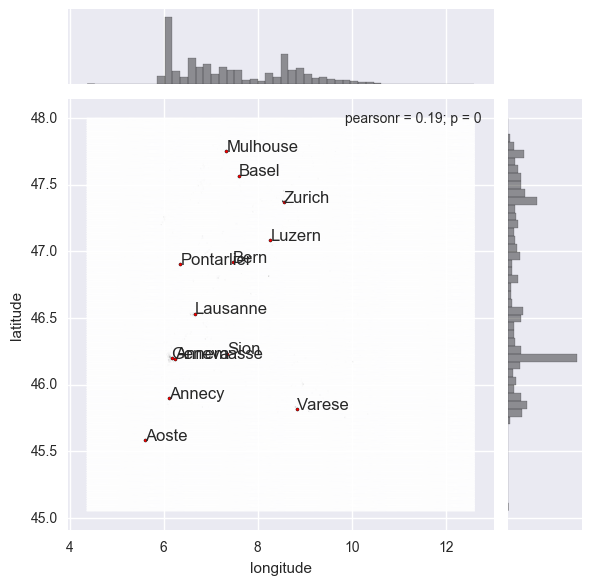

In [15]:
g = sns.jointplot(x=df.longitude, y=df.latitude, kind="hex", color="k");
for city, coord in main_cities.items():
    g.ax_joint.scatter(coord[1], coord[0], marker='o', c='r', s=5)
    g.ax_joint.annotate(city, xy=(coord[1], coord[0]), xytext=(coord[1], coord[0]))
plt.show()

In [16]:
#UserLocation is not reliable information. 
#Takes too much resource to find a way to filter useless and helphful information.
#we reverse query our coordinates
df = df.drop(['userLocation'], axis=1)
df.head()

,ID,userID,createdAt,longitude,latitude
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951
3,927018013,14703863,2010-02-23 07:51:47,8.81749,47.2288
4,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199


In [17]:
count_users = pd.DataFrame(df.groupby(['userID']).size())
count_users.columns = ['count']
count_users = count_users.sort_values(by=['count'], ascending=True)
count_users = count_users.reset_index()

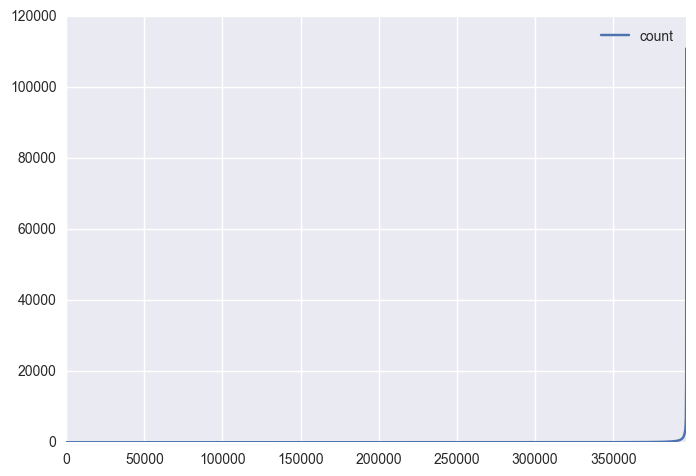

In [18]:
#plot distribution of tweets per user (add legend)
count_users.plot(y='count', use_index=True)
plt.show()

In [19]:
#5% of users have more than 70% of tweets. 
#we remove users with a number of tweets below a certain threshold.
threshold = 100
before = len(count_users)
count_users = count_users[count_users['count'] >= threshold]
after = len(count_users)
print('Percentage of user loss: ',(before-after)*100/before)

Percentage of user loss:  95.34406577590921


In [20]:
ids_to_keep = list(count_users.userID)
tweets = df[df.userID.isin(ids_to_keep)]
len(tweets)

13186324

In [21]:
#check types
tweets.dtypes

ID             int32
userID         int64
createdAt     object
longitude    float64
latitude     float64
dtype: object

In [22]:
#convert createdAt to date
tweets['createdAt'] = pd.DatetimeIndex(tweets['createdAt'])
#tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
print(tweets.dtypes)

ID                    int32
userID                int64
createdAt    datetime64[ns]
longitude           float64
latitude            float64
dtype: object


C:\Users\Alain\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [23]:
tweets = tweets.reset_index(drop=True)
tweets.head()

,ID,userID,createdAt,longitude,latitude
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951
3,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199
4,928080163,14393717,2010-02-23 08:40:13,6.63428,46.5191


# 4. Mobility Pattern

In [24]:
#location too precise. Need to compare areas/spots between them. Lower coordinate precision.
#https://en.wikipedia.org/wiki/Decimal_degrees
#precision to 3 decimals: equateur => 80m 
#precision to 2 decimals: equateur => 780m 

tweets['areaLat'] = tweets.apply(lambda r: float('%.2f' % r.latitude), axis=1)
tweets['areaLong'] = tweets.apply(lambda r: float('%.2f' % r.longitude), axis=1)
tweets.head()

,ID,userID,createdAt,longitude,latitude,areaLat,areaLong
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,46.95,7.44
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,47.37,8.54
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,46.20,6.13
3,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,46.52,6.63
4,928080163,14393717,2010-02-23 08:40:13,6.63428,46.5191,46.52,6.63


In [25]:
#Indicate if tweet during work hour or not
#set work hours being 8:00-18:00
tweets['@workHour'] = (tweets['createdAt'].dt.hour <= 18) & (tweets['createdAt'].dt.hour >= 8)
tweets.head()

,ID,userID,createdAt,longitude,latitude,areaLat,areaLong,@workHour
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,46.95,7.44,False
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,47.37,8.54,False
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,46.20,6.13,False
3,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,46.52,6.63,True
4,928080163,14393717,2010-02-23 08:40:13,6.63428,46.5191,46.52,6.63,True


## 4.1 Home and Work Place Extraction

### 4.1.1 Work place detection

In [26]:
at_work = tweets[tweets['@workHour']]
at_work.head()

,ID,userID,createdAt,longitude,latitude,areaLat,areaLong,@workHour
3,927264351,14393717,2010-02-23 08:02:57,6.63254,46.5199,46.52,6.63,True
4,928080163,14393717,2010-02-23 08:40:13,6.63428,46.5191,46.52,6.63,True
5,929214686,14260616,2010-02-23 09:32:09,8.29953,47.4829,47.48,8.30,True
6,929803298,14657884,2010-02-23 09:59:41,6.13870,46.1750,46.17,6.14,True
7,931855097,9962022,2010-02-23 11:28:27,6.33641,46.4631,46.46,6.34,True


In [27]:
def place_24hdiff(name, most_freq, place):
    if place == "work":
        tw = at_work[(at_work.userID == name) & (at_work.areaLong == most_freq[1]) & (at_work.areaLat == most_freq[0])]
    else:
        tw = nat_work[(nat_work.userID == name) & (nat_work.areaLong == most_freq[1]) & (nat_work.areaLat == most_freq[0])]
    #return true if day distance >=1        
    for i1, row1 in tw.iterrows():
        for i2, row2 in tw.iterrows():
            d = row1.createdAt - row2.createdAt
            if abs(d.days) >= 1:
                return True
    return False

def most_freq_coord(group, threshold, place):
    lat_long = list(zip(group.areaLat, group.areaLong))
    c = Counter(lat_long)
    most_freq = list(c)[0]
    n = c[most_freq]
    while not place_24hdiff(group.name, most_freq, place):
        c.pop(most_freq, 0)
        if len(c) == 0:
            #no places with valid diff: return last one with frequence 0 which will be deleted with threshold
            return pd.Series({'freqLat': most_freq[0], 'freqLong': most_freq[1], 'frequence': 0})
        else:
            most_freq = list(c)[0]
            n = c[most_freq]
    #out of while loop: means we have a valid place (1 day diff)
    return pd.Series({'freqLat': most_freq[0], 'freqLong': most_freq[1], 'frequence': n})

In [28]:
threshold = 10

In [29]:
work_freq = at_work.groupby(['userID']).apply(lambda g : most_freq_coord(g,threshold, "work"))
print(len(work_freq))
work_freq.head()

18453


,freqLat,freqLong,frequence
userID,,,
1497,47.59,8.02,3.0
2397,47.59,8.21,2.0
2623,47.76,8.84,2.0
5267,47.46,8.59,5.0
5757,47.67,9.41,75.0


In [30]:
#apply threshold on frequence
len(work_freq[work_freq.frequence < threshold])

10240

In [31]:
#we would loose 950 users that tweeted less than threshold tweets from their potential work
#save index of to_remove users
work_to_remove = work_freq[work_freq.frequence < threshold].index.values.tolist()
len(work_to_remove)

10240

### 4.1.2 Home detection

In [32]:
nat_work = tweets[~tweets['@workHour']]
nat_work.head()

,ID,userID,createdAt,longitude,latitude,areaLat,areaLong,@workHour
0,924163322,17341045,2010-02-23 05:55:51,7.43926,46.9489,46.95,7.44,False
1,924911820,7198282,2010-02-23 06:22:40,8.53781,47.3678,47.37,8.54,False
2,926639767,14657884,2010-02-23 07:34:25,6.13396,46.1951,46.20,6.13,False
16,954731115,6016562,2010-02-23 21:58:49,6.62680,46.5072,46.51,6.63,False
17,957072936,14657884,2010-02-23 22:56:23,6.14474,46.1958,46.20,6.14,False


In [33]:
threshold = 10

In [34]:
home_freq = nat_work.groupby(['userID']).apply(lambda g: most_freq_coord(g, threshold, "home"))
print(len(home_freq))
home_freq.head()

18444


,freqLat,freqLong,frequence
userID,,,
1497,47.38,8.54,51.0
2397,46.24,6.09,2.0
2623,47.63,7.68,9.0
5267,46.20,6.14,12.0
5757,47.73,9.40,164.0


In [35]:
#apply threshold on frequence
len(home_freq[home_freq.frequence < threshold])

9168

In [36]:
#we would loose 843 users that tweeted less than 10 tweets from their potential home
#save index of to_remove users
home_to_remove = home_freq[home_freq.frequence < threshold].index.values.tolist()
len(home_to_remove)

9168

### 4.1.3 Data Merge: Home | Work

In [37]:
#for now do not remove places with frequence = 1
#we do not separate analysis over the years
count_users = count_users.set_index(['userID'])

In [38]:
#join 3 dataframes: work_freq, home_freq, count_users
users = pd.merge(work_freq, home_freq,how='inner', left_index=True, right_index=True, )
columns = ['workLat', 'workLong', 'workTweets', 'homeLat', 'homeLong', 'homeTweets']
users = pd.merge(users, count_users, how='inner', left_index=True, right_index=True, suffixes=('_x', '_y'))
columns.append('#tweets')
users.columns = columns
users.head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets
userID,,,,,,,
92623079,47.37,8.54,3.0,47.37,8.54,97.0,100
70251991,47.41,9.19,25.0,47.41,9.19,41.0,100
264695368,46.23,6.08,5.0,46.20,6.14,26.0,100
396139120,45.91,8.33,35.0,45.87,8.40,5.0,100
283440943,46.07,6.57,15.0,46.08,6.57,15.0,100


In [39]:
users['userID'] = users.index.values
users = users.reset_index(drop=True)
#users = users[users.columns[-1:]+users.columns[:-1]]
users.head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID
0,47.37,8.54,3.0,47.37,8.54,97.0,100,92623079
1,47.41,9.19,25.0,47.41,9.19,41.0,100,70251991
2,46.23,6.08,5.0,46.20,6.14,26.0,100,264695368
3,45.91,8.33,35.0,45.87,8.40,5.0,100,396139120
4,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943


In [40]:
#remove users that did not validate conditions on work/home tweet frequence threshold
to_remove = home_to_remove + work_to_remove
print(len(users))
users = users[~users.userID.isin(to_remove)]
print(len(users))

18425
5270


In [41]:
#save dataframe
users.to_csv('users_merged.csv', index=False)

## 4.2 Home-Work route evaluation

### 4.2.1 Administrative locations detection

In [42]:
users = pd.read_csv('users_merged.csv', sep=',')
users.head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID
0,47.41,9.19,25.0,47.41,9.19,41.0,100,70251991
1,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943
2,47.37,8.54,54.0,47.37,8.54,20.0,100,304614459
3,46.20,6.16,50.0,46.20,6.16,34.0,100,1640784745
4,47.36,7.90,37.0,47.36,7.90,63.0,100,1384072519


- Country  

In [43]:
geolocator = Nominatim()
countries = []
cache = {}
for i, row in users.iterrows():
    w = 0
    h = 0
    if cache.get((row.homeLat, row.homeLong)):
        home = cache[(row.homeLat, row.homeLong)]
        h = home.address.split(', ')[-1]
    else:
        home = geolocator.reverse(str(row.homeLat)+", "+str(row.homeLong))#.address.split(', ')[-1]
        cache[(row.homeLat, row.homeLong)] = home
        h = home.address.split(', ')[-1]
        time.sleep(0.5)
    if cache.get((row.workLat, row.workLong)):
        work = cache[(row.workLat, row.workLong)]
        w = work.address.split(', ')[-1]
    else:
        work = geolocator.reverse(str(row.workLat)+", "+str(row.workLong))#.address.split(', ')[-1]
        cache[(row.workLat, row.workLong)] = work
        w = work.address.split(', ')[-1]
        time.sleep(0.5)
    if w == "Svizra":
        w = "Suisse"
    if h == "Svizra":
        h = "Suisse"
    countries.append((h,w))

In [44]:
countries[:10]

[('Suisse', 'Suisse'),
 ('France', 'France'),
 ('Suisse', 'Suisse'),
 ('Suisse', 'Suisse'),
 ('Suisse', 'Suisse'),
 ('Suisse', 'Suisse'),
 ('Suisse', 'Suisse'),
 ('Suisse', 'Suisse'),
 ('France', 'France'),
 ('Suisse', 'Suisse')]

In [45]:
#add countries to users
c = pd.DataFrame(countries, columns=['homeCountry', 'workCountry'])
users = pd.concat([users, c], axis=1)
users.head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID,homeCountry,workCountry
0,47.41,9.19,25.0,47.41,9.19,41.0,100,70251991,Suisse,Suisse
1,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943,France,France
2,47.37,8.54,54.0,47.37,8.54,20.0,100,304614459,Suisse,Suisse
3,46.20,6.16,50.0,46.20,6.16,34.0,100,1640784745,Suisse,Suisse
4,47.36,7.90,37.0,47.36,7.90,63.0,100,1384072519,Suisse,Suisse


- Cantons

In [46]:
#detect Cantons
def get_cantons(row):
    if row.homeCountry == "Suisse":
        homecant = cache[(row.homeLat, row.homeLong)].address.split(', ')[-6]
    else:
        homecant = "-"
    if row.workCountry == "Suisse":
        workcant = cache[(row.workLat, row.workLong)].address.split(', ')[-6]
    else:
        workcant = "-"
    return (homecant, workcant)

#add cantons to users
cantons = list(users.apply(get_cantons, axis=1))
cantons = pd.DataFrame(cantons, columns=['homeCanton', 'workCanton'])
users = pd.concat([users, cantons], axis=1)

In [47]:
users.head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID,homeCountry,workCountry,homeCanton,workCanton
0,47.41,9.19,25.0,47.41,9.19,41.0,100,70251991,Suisse,Suisse,Sankt Gallen,Sankt Gallen
1,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943,France,France,-,-
2,47.37,8.54,54.0,47.37,8.54,20.0,100,304614459,Suisse,Suisse,Zürich,Zürich
3,46.20,6.16,50.0,46.20,6.16,34.0,100,1640784745,Suisse,Suisse,Genève,Genève
4,47.36,7.90,37.0,47.36,7.90,63.0,100,1384072519,Suisse,Suisse,Solothurn,Solothurn


In [51]:
users.to_csv('users_locations.csv', encoding='utf-8', index=False)

### 4.2.2 Distance Home-Work

In [52]:
users = pd.read_csv('users_locations.csv', encoding='utf-8')
users.head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID,homeCountry,workCountry,homeCanton,workCanton
0,47.41,9.19,25.0,47.41,9.19,41.0,100,70251991,Suisse,Suisse,Sankt Gallen,Sankt Gallen
1,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943,France,France,-,-
2,47.37,8.54,54.0,47.37,8.54,20.0,100,304614459,Suisse,Suisse,Zürich,Zürich
3,46.20,6.16,50.0,46.20,6.16,34.0,100,1640784745,Suisse,Suisse,Genève,Genève
4,47.36,7.90,37.0,47.36,7.90,63.0,100,1384072519,Suisse,Suisse,Solothurn,Solothurn


In [182]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

def dist(row):
    if (row.workLat == row.homeLat) and (row.workLong == row.homeLong):
        return 0
    else:
        return haversine(row.workLong, row.workLat, row.homeLong, row.homeLat)

In [54]:
users['distance'] = users.apply(dist, axis=1)

In [55]:
users[users.distance != 0.0].head()

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID,homeCountry,workCountry,homeCanton,workCanton,distance
1,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943,France,France,-,-,1.111251
9,46.23,7.36,28.0,46.23,7.37,17.0,100,453014694,Suisse,Suisse,Valais - Wallis,Valais - Wallis,0.768725
13,46.19,6.74,13.0,46.20,6.77,11.0,100,489605957,France,France,-,-,2.561270
20,47.14,6.68,25.0,47.34,6.74,11.0,100,736829012190826496,France,France,-,-,22.681339
33,47.38,8.54,19.0,47.39,8.62,16.0,100,23299229,Suisse,Suisse,Zürich,Zürich,6.120866


### 4.2.3 Detect closer main cities (work/home)

In [56]:
def get_closer(row, where):
    if where == 'work':
        lat = row.workLat
        long = row.workLong
    else:
        lat = row.homeLat
        long = row.homeLong
    d = 10000
    closer = ""
    for city, coord in main_cities.items():
        new = haversine(long, lat, coord[1], coord[0])
        if new < d:
            d = new
            closer = city
    return (closer, d)


users['closer to home'] = users.apply(lambda r: get_closer(r, "home"), axis=1)
users['closer to work'] = users.apply(lambda r: get_closer(r, "work"), axis=1)

In [57]:
users[users.homeCountry != users.workCountry]

,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID,homeCountry,workCountry,homeCanton,workCanton,distance,closer to home,closer to work
90,47.64,9.17,20.0,47.71,9.15,48.0,102,1103913025,Deutschland,Suisse,-,Thurgau,7.921398,"(Zurich, 59.005703918453214)","(Zurich, 55.57735813124365)"
280,45.83,6.81,10.0,46.01,7.33,14.0,107,2933943639,Suisse,Italia,Valais - Wallis,-,44.900323,"(Sion, 24.86200859270752)","(Annecy, 54.20984604150633)"
692,47.79,9.16,22.0,46.29,9.47,11.0,121,19582762,Italia,Deutschland,-,-,168.332352,"(Varese, 72.24411256901706)","(Zurich, 65.6044699599605)"
874,47.14,9.52,102.0,46.81,8.22,21.0,128,1869384722,Suisse,Liechtenstein,Obwalden,-,105.168264,"(Luzern, 30.57643122586675)","(Zurich, 77.37815489300748)"
876,46.48,9.83,15.0,46.16,9.45,47.0,128,447425578,Italia,Suisse,-,Graubünden - Grigioni - Grischun,45.989359,"(Varese, 61.36713651236989)","(Varese, 106.7125949215535)"
916,45.92,6.87,26.0,45.83,6.81,41.0,130,94654782,Italia,France,-,-,11.026069,"(Annecy, 54.20984604150633)","(Sion, 50.80580595438094)"
1045,45.99,7.74,13.0,46.13,8.25,73.0,136,293582360,Italia,Suisse,-,Valais - Wallis,42.291600,"(Varese, 56.451584852213564)","(Sion, 40.41869246967872)"
1198,46.21,6.09,43.0,45.88,9.94,11.0,143,15444313,Italia,Suisse,-,Genève,299.180318,"(Varese, 86.47558790452284)","(Geneva, 6.002563584409143)"
1272,46.03,7.00,10.0,45.83,6.95,10.0,146,3708674235,Italia,Suisse,-,Valais - Wallis,22.558514,"(Sion, 54.41377037243955)","(Sion, 35.16923964700747)"
1433,46.25,6.10,22.0,46.23,6.11,26.0,152,613828174,Suisse,France,Genève,-,2.351646,"(Geneva, 5.488378192021087)","(Geneva, 7.5608818000857685)"


### 4.2.4 Route Time: home-work

In [58]:
import requests
import json
import codecs
#API_KEY imported from file

def get_time(row):
    if (row.homeLat == row.workLat) and (row.homeLong == row.workLong):
        return 0
    else:
        src = {'lat':row.homeLat, 'long':row.homeLong}
        dest = {'lat': row.workLat, 'long': row.workLong}
        params = {
            'key': API_KEY,
            'outFormat': "json",
            'inFormat': "json"
        }
        request_body = {
            'locations': [
                {'latLng': {'lat': src['lat'], 'lng': src['long']}},
                {'latLng': {'lat': dest['lat'], 'lng': dest['long']}}
                ]
            }
        r=requests.post('https://www.mapquestapi.com/directions/v2/route',
                        params=params, 
                        data=json.dumps(request_body)
                       )
        if r.status_code != 200:
            # We didn't get a response from Mapquest
            return -1
        return r.json()['route']['time']/60

users['routeTime'] = users.apply(get_time, axis=1)

In [59]:
test = users[users.routeTime != 0]
print(len(test))
test.head()

1496


,workLat,workLong,workTweets,homeLat,homeLong,homeTweets,#tweets,userID,homeCountry,workCountry,homeCanton,workCanton,distance,closer to home,closer to work,routeTime
1,46.07,6.57,15.0,46.08,6.57,15.0,100,283440943,France,France,-,-,1.111251,"(Annemasse, 28.571855010308788)","(Annemasse, 29.085366517412528)",3.850000
9,46.23,7.36,28.0,46.23,7.37,17.0,100,453014694,Suisse,Suisse,Valais - Wallis,Valais - Wallis,0.768725,"(Sion, 1.5805339707161008)","(Sion, 0.8516928200460542)",2.800000
13,46.19,6.74,13.0,46.20,6.77,11.0,100,489605957,France,France,-,-,2.561270,"(Lausanne, 37.875547166117336)","(Lausanne, 38.56116082254647)",24.650000
20,47.14,6.68,25.0,47.34,6.74,11.0,100,736829012190826496,France,France,-,-,22.681339,"(Pontarlier, 56.5556542287537)","(Pontarlier, 35.991432602857294)",40.600000
33,47.38,8.54,19.0,47.39,8.62,16.0,100,23299229,Suisse,Suisse,Zürich,Zürich,6.120866,"(Zurich, 5.870861078020564)","(Zurich, 1.6615021190898316)",14.066667


In [60]:
users.to_csv('users_final.csv', encoding='utf-8', index=False)

# 5. Statistics on Data

In [3]:
users = pd.read_csv('users_final.csv', encoding = "ISO-8859-1")
print('Our final dataset contains '+str(len(users))+' users.')

Our final dataset contains 5270 users.


## 5.1 Population locations

### 5.1.1 Users distribution

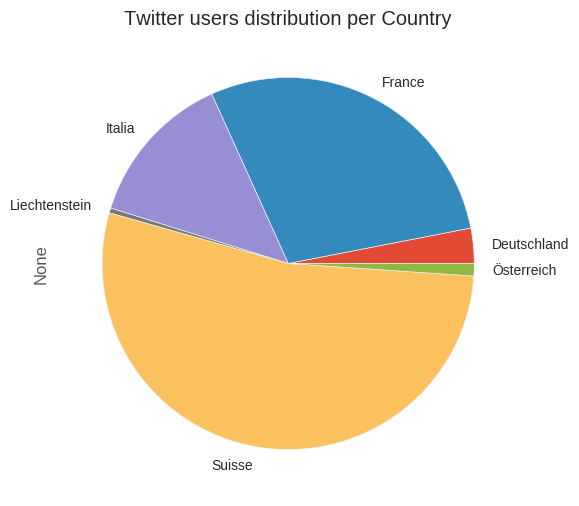

In [4]:
plt.style.use('ggplot')
per_countries = users[users.homeCountry == users.workCountry].groupby('homeCountry').size()
per_countries.columns = ['Number of users']
per_countries.plot.pie(figsize=(6,6), title="Twitter users distribution per Country")
plt.savefig('tweetpercountry.png')
plt.show()

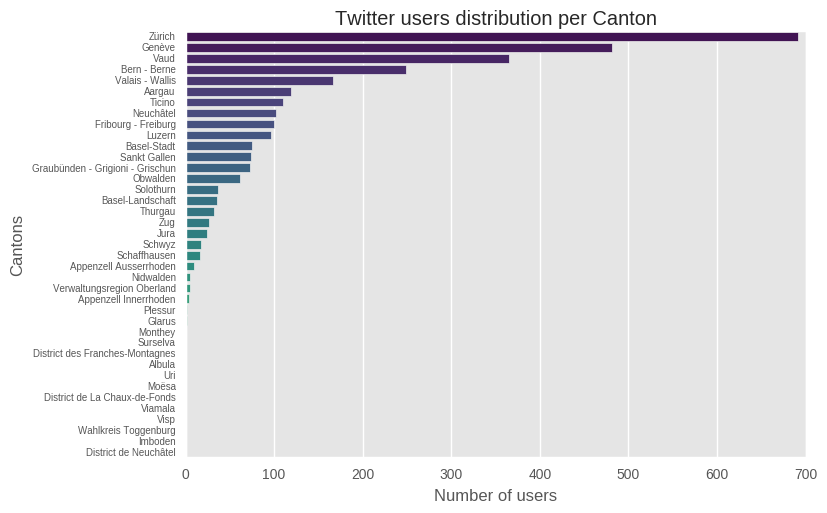

In [16]:
swiss = users[(users.homeCountry == users.workCountry) & (users.homeCountry == "Suisse")]

swiss_equals = swiss[swiss.homeCanton == swiss.workCanton]
g1 = pd.DataFrame(swiss_equals.groupby('homeCanton').size())
g1.columns = ['c1']

swiss_differs = swiss[swiss.homeCanton != swiss.workCanton]
g2 = pd.DataFrame(swiss_differs.groupby('homeCanton').size())
g2.columns = ['c2']

g3 = pd.DataFrame(swiss_differs.groupby('workCanton').size())
g3.columns = ['c3']

g = pd.concat([g1,g2,g3], axis=1)
g = g.fillna(0)
g['cantons'] = g.index.values
g['count'] = g['c1']+g['c2']+g['c3']
g = g.drop(['c1', 'c2', 'c3'], axis=1)
g = g.sort_values(by=['count'], ascending=False)

ax = sns.barplot(x="count", y="cantons", data=g,
            label="Number of users", palette="viridis")
ax.set(ylabel="Cantons",xlabel="Number of users")
sns.plt.title("Twitter users distribution per Canton")
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['xtick.labelsize'] = 10
plt.savefig('tweetspercanton.png')
plt.show()

### 5.1.2 Borderers

In [6]:
#globally
borderers = users[users.homeCountry != users.workCountry]
print("Number of detected borderers: ", len(borderers))
print("Percentage of detected borderers: ", 100*(len(borderers)/len(users)))

Number of detected borderers:  67
Percentage of detected borderers:  1.2713472485768502


In [7]:
print("Different detected movements: ")
flows = pd.DataFrame(borderers.groupby(['homeCountry', 'workCountry']).size())
flows

Different detected movements: 


0
homeCountry workCountry      
Deutschland Suisse          2
France      Italia          2
            Suisse         25
Italia      Deutschland     1
            France          3
            Suisse          8
Suisse      France         15
            Italia          4
            Liechtenstein   2
            Österreich      4
Österreich  Suisse          1

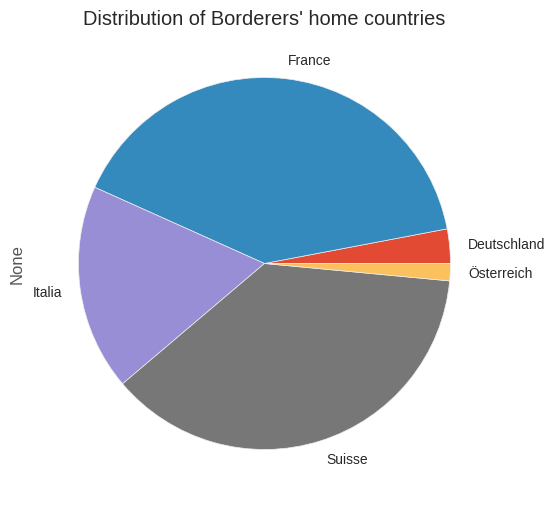

In [8]:
grouped = borderers.groupby('homeCountry').size()

plt.style.use('ggplot')
grouped.plot.pie(figsize=(6,6), title="Distribution of Borderers' home countries")
plt.savefig('borderersfromcountry.png')
plt.show()

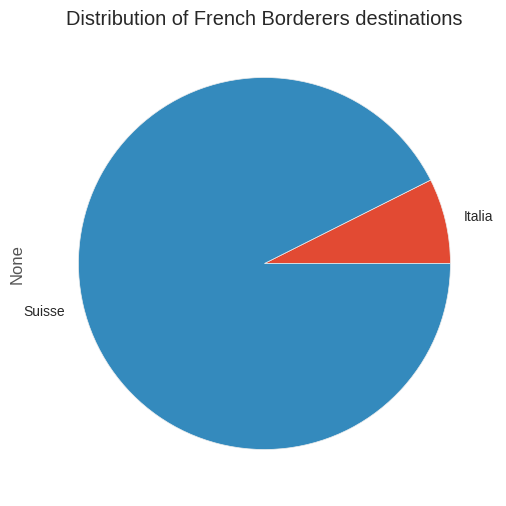

In [9]:
french = borderers[(borderers.homeCountry == "France") & (borderers.workCountry != "France")]
fr = french.groupby('workCountry').size()
plt.style.use('ggplot')
fr.plot.pie(figsize=(6,6), title="Distribution of French Borderers destinations")
plt.savefig('frenchborderers.png')
plt.show()

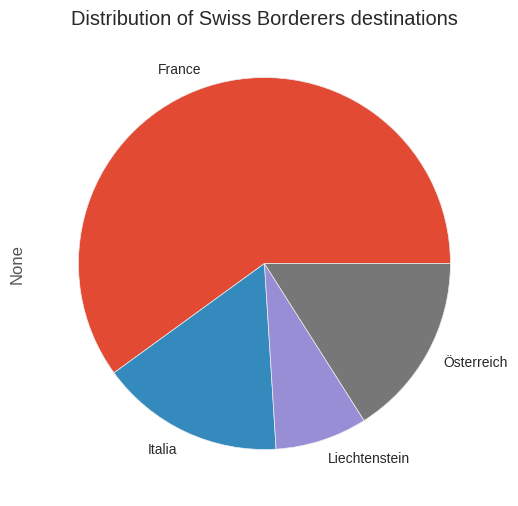

In [19]:
swiss = borderers[(borderers.homeCountry == "Suisse") & (borderers.workCountry != "Suisse")]
ch = swiss.groupby('workCountry').size()
plt.style.use('ggplot')
ch.plot.pie(figsize=(6,6), title="Distribution of Swiss Borderers destinations")
plt.savefig('swissborderers.png')
plt.show()

### 5.1.3 Swiss working and living in different Cantons

In [11]:
#globally
diffcant = users[(users.homeCountry == "Suisse") & (users.homeCanton != users.workCanton)]
swiss = users[users.homeCountry == "Suisse"]
print("Number of detected users in different canton: ", len(diffcant))
print("Percentage of detected users among swiss: ", 100*(len(diffcant)/len(swiss)))

Number of detected users in different canton:  243
Percentage of detected users among swiss:  8.681672025723474


In [12]:
print("Different detected movements: ")
main_cantons = ['Zürich', "Genève", "Vaud", "Bern - Berne", "Valais - Wallis", "Aargau"]
flows = pd.DataFrame(diffcant[diffcant.homeCanton.isin(main_cantons)].groupby(['homeCanton', 'workCanton']).size())

flows

Different detected movements: 


0
homeCanton      workCanton                          
Aargau          Luzern                             1
                Solothurn                          2
                Vaud                               1
                Zug                                1
                Zürich                            16
Bern - Berne    -                                  1
                Basel-Stadt                        1
                Luzern                             1
                Obwalden                           1
                Solothurn                          2
                Valais - Wallis                    2
                Vaud                               2
                Zürich                             9
Genève          -                                  8
                Aargau                             1
                Basel-Landschaft                   1
                Basel-Stadt                        1
                Bern - Berne                       1
                Obwalden                           3
                Valais - Wallis                    2
                Vaud                               3
                Zürich                             6
Valais - Wallis -                                  3
                Genève                             1
                Luzern                             1
                Neuchâtel                          1
                Vaud                               4
                Zürich                             1
Vaud            Aargau                             3
                Fribourg - Freiburg                5
                Genève                             9
                Neuchâtel                          1
                Sankt Gallen                       1
                Ticino                             1
                Valais - Wallis                    3
                Zürich                             3
Zürich          -                                  2
                Aargau                             6
                Basel-Landschaft                   1
                Basel-Stadt                        1
                Bern - Berne                      12
                Genève                             6
                Graubünden - Grigioni - Grischun   1
                Imboden                            1
                Luzern                             4
                Sankt Gallen                       3
                Schaffhausen                       1
                Thurgau                            1
                Ticino                             4
                Valais - Wallis                    1
                Vaud                               8
                Zug                                1

### 5.1.4 Home Location vs Work Location 

In [13]:
#percentage working at home or not working
working_home = users[(users.workLat == users.homeLat) & (users.workLong == users.homeLong)]

In [14]:
n = len(working_home)
perc = 100*(n/len(users))
print("Number of users working at home or not working: "+str(n))
print("Percentage of people working at home: "+str(int(perc))+"%")

Number of users working at home or not working: 3753
Percentage of people working at home: 71%


High number. Given our assumptions it just means that tweets during the day and during the night were sent at the same place. 

Distribution of working@home per Canton. We discard people living and working in different canton.

In [15]:
def work_percentage(group):
    n = len(group[group["working@home"]])
    N = len(group)
    perc = 100*(n/N)
    return pd.Series({'@home': perc, 'total': 100})


per_cant = users[(users.homeCanton == users.workCanton)\
                 & (users.homeCountry == "Suisse") & (users.homeCanton.isin(main_cantons))]\
.groupby(['workCanton']).apply(work_percentage)

per_cant['Canton'] = per_cant.index.values
per_cant = per_cant.reset_index(drop=True)
per_cant.head()

KeyError: 'working@home'

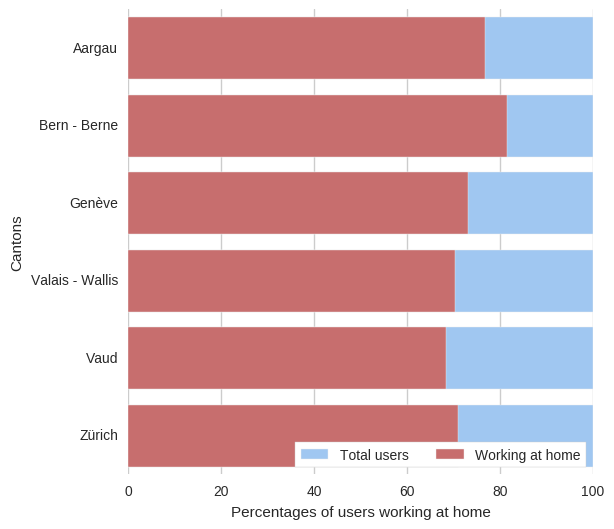

In [271]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 6))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="total", y="Canton", data=per_cant,
            label="Total users", color="b")

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="@home", y="Canton", data=per_cant,
            label="Working at home", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="Cantons",xlabel="Percentages of users working at home")
sns.despine(left=True, bottom=True)

plt.show()

## 5.2 Population routing: Home-Work

### 5.2.1 Average Swiss:
- closeness to center of town
- distance to work
- time to go to work by car

In [273]:
swiss = users[(users.homeCountry == "Suisse")]

s= list(swiss['closer to home'])
split = list(map(lambda x: float(x.split(', ')[1][:-1]), s))

l = list(filter(lambda x: x < 20,map(float, split)))
print("Distance home from center of town swiss:")
pd.DataFrame(l).describe()

Distance home from center of town swiss:


,0
count,1766.000000
mean,5.874809
std,5.108324
min,0.253818
25%,1.674336
50%,4.218802
75%,7.453746
max,19.995448


In [274]:
print("Distance from work swiss:")
pd.DataFrame(swiss['distance']).describe()

Distance from work swiss:


,distance
count,2799.000000
mean,8.615459
std,30.302306
min,0.000000
25%,0.000000
50%,0.000000
75%,1.351467
max,256.732558


In [275]:
print("Route Time Average Swiss:")
pd.DataFrame(swiss['routeTime']).describe()

Route Time Average Swiss:


,routeTime
count,2799.000000
mean,10.077349
std,27.965784
min,0.000000
25%,0.000000
50%,0.000000
75%,5.891667
max,299.500000


### 5.2.2 Per canton

In [277]:
def avg_dtime(group):
    return pd.Series({"avg distance": group["distance"].mean(), "avg time": group["routeTime"].mean()})


cant_dist_time = pd.DataFrame(swiss[swiss.homeCanton.isin(main_cantons)].groupby('homeCanton').apply(avg_dtime))
print("Average distance from work and time travel to work per main Cantons:")
cant_dist_time

Average distance from work and time travel to work per main Cantons:


,avg distance,avg time
homeCanton,,
Aargau,7.382032,9.219159
Bern - Berne,8.722460,10.780277
Genève,7.562918,7.817768
Valais - Wallis,6.699704,12.198637
Vaud,8.200027,9.538109
Zürich,11.314645,11.595344


### 5.2.3 For Borderers

In [279]:
print("Distance and time from home to work:")
borderers[["distance", "routeTime"]].describe()

Distance and time from home to work:


,distance,routeTime
count,67.000000,67.000000
mean,61.422583,73.350746
std,68.343603,71.567629
min,1.539969,0.000000
25%,10.807168,19.416667
50%,35.774367,46.866667
75%,91.818483,105.566667
max,299.180318,285.116667


## 5.3 Exploration of cities home/work locations
- Geneva
- Zürich

In [331]:
city = users[['workLat', 'workLong', 'closer to work', 'homeLat', 'homeLong', 'closer to home']]

w = list(city['closer to work'])
work = list(map(lambda x: float(x.split(', ')[1][:-1]), w))
citywork = list(map(lambda x: x.split(', ')[0][2:-1], w))
city['closer to work'] = pd.DataFrame(work)
city['citywork'] = pd.DataFrame(citywork)

h= list(city['closer to home'])
home = list(map(lambda x: float(x.split(', ')[1][:-1]), h))
cityhome = list(map(lambda x: x.split(', ')[0][2:-1], h))
city['closer to home'] = pd.DataFrame(home)
city['cityhome'] = pd.DataFrame(cityhome)

geneva = city[(city.cityhome == "Geneva") | (city.citywork == "Geneva")]
geneva = geneva[(geneva['closer to home'] < 15) & (geneva['closer to work'] < 15)]
geneva = geneva[(geneva.workLat != geneva.homeLat) & (geneva.workLong != geneva.homeLong)]

zurich = city[(city.cityhome == "Zurich") | (city.citywork == "Zurich")]
zurich = zurich[(zurich['closer to home'] < 30) & (zurich['closer to work'] < 30)]
zurich = zurich[(zurich.workLat != zurich.homeLat) & (zurich.workLong != zurich.homeLong)]

/home/hparmantier/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/hparmantier/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/hparmantier/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [332]:
print("Saving of Zurich neighborhood...")
map_1 = folium.Map(location=main_cities['Zurich'], zoom_start=13,tiles='Stamen Toner')
for index, row in zurich.iterrows():
    folium.CircleMarker([row.workLat, row.workLong], popup=str(row.workLat)+','+str(row.workLong),
                    color='#fe2e2e',fill_color='#fe2e2e', radius =50).add_to(map_1)
    folium.CircleMarker([row.homeLat, row.homeLong], popup=str(row.homeLat)+','+str(row.homeLong),
                  color='#0000FF',fill_color='#0000FF', radius=50).add_to(map_1)
map_1.save('zurich.html')
print("Saved.")

Saving of Zurich neighborhood...
Saved.


In [333]:
print("Saving of Geneva neighborhood...")
map_1 = folium.Map(location=main_cities['Geneva'], zoom_start=13,tiles='Stamen Toner')
for index, row in geneva.iterrows():
    folium.CircleMarker([row.workLat, row.workLong], popup=str(row.workLat)+','+str(row.workLong),
                    color='#fe2e2e',fill_color='#fe2e2e', radius =50).add_to(map_1)
    folium.CircleMarker([row.homeLat, row.homeLong], popup=str(row.homeLat)+','+str(row.homeLong),
                  color='#0000FF',fill_color='#0000FF', radius=50).add_to(map_1)
map_1.save('geneva.html')
print("Saved.")

Saving of Geneva neighborhood...
Saved.
